In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.datasets import cifar10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)
print("Test images:", x_test.shape)
print("Test labels:", y_test.shape)

Train images: (50000, 3072)
Train labels: (50000, 1)
Test images: (10000, 3072)
Test labels: (10000, 1)


array([0.23137255, 0.24313726, 0.24705882, ..., 0.48235294, 0.36078432,
       0.28235295], shape=(3072,), dtype=float32)

In [5]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)

In [6]:
from keras import models
from keras import layers

model = models.Sequential([
    layers.Input(shape=(32*32*3,)),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(10, activation='softmax')
])

In [7]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

model.compile(
    metrics=["accuracy"],
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy"
)

In [8]:
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

ckpt = ModelCheckpoint(
    "best.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [10]:
history = model.fit(
    x_train, y_train_onehot,
    epochs=150,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping, ckpt, lr_scheduler],
    verbose=1
)

Epoch 1/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2149 - loss: 2.4754
Epoch 1: val_loss improved from None to 1.82471, saving model to best.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.2609 - loss: 2.2271 - val_accuracy: 0.3366 - val_loss: 1.8247 - learning_rate: 5.0000e-04
Epoch 2/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3171 - loss: 1.9234
Epoch 2: val_loss did not improve from 1.82471
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.3297 - loss: 1.8842 - val_accuracy: 0.3150 - val_loss: 1.8923 - learning_rate: 5.0000e-04
Epoch 3/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3641 - loss: 1.7757
Epoch 3: val_loss did not improve from 1.82471
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.3679 - loss: 1.7635 - val_accuracy: 0.3204 - val_loss: 1.9370 - learning_rate: 5.0000e-04
Epoch 4/150
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3781 - loss: 1.7239
Epoch 4: val_loss improved from 1.824

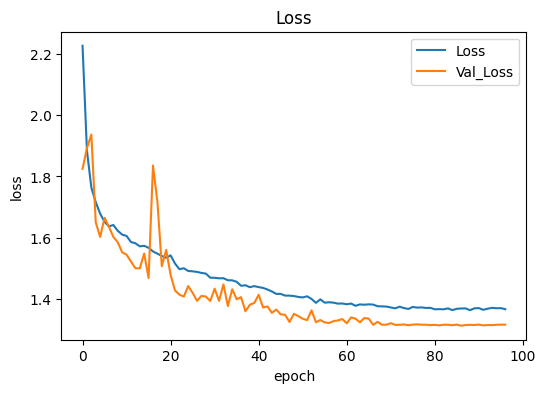

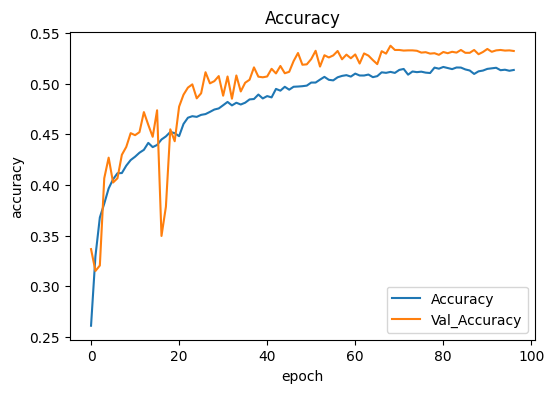

In [11]:
import matplotlib.pyplot as plt

hist = history.history

plt.figure(figsize=(6,4))
plt.plot(hist['loss'], label='Loss')
plt.plot(hist['val_loss'], label='Val_Loss')
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss"); plt.show()

if "accuracy" in hist:
    plt.figure(figsize=(6,4))
    plt.plot(hist['accuracy'], label='Accuracy')
    plt.plot(hist['val_accuracy'], label='Val_Accuracy')
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy"); plt.show()

In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test loss: 1.3203
Test accuracy: 0.5298


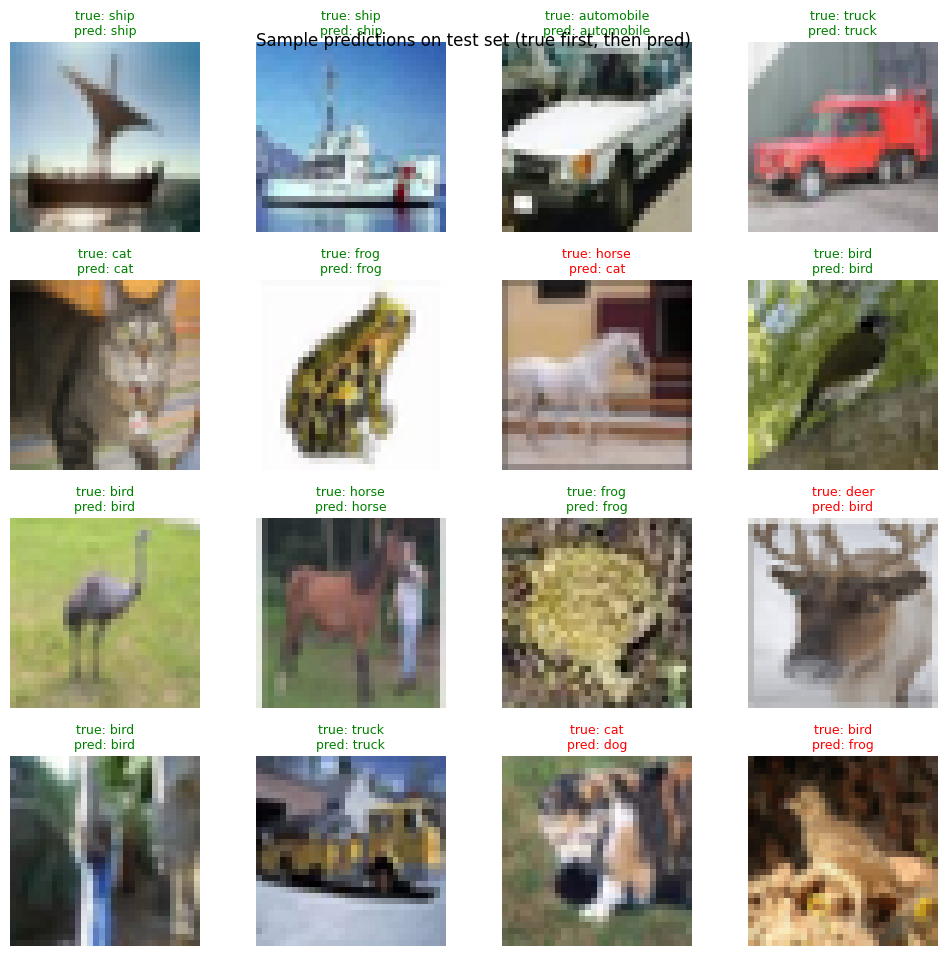

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# cifar10 class names
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

yt = y_test
if yt.ndim == 2 and yt.shape[1] == 10:
    y_true = yt.argmax(axis=1)
else:
    y_true = yt.reshape(-1)

probs = model.predict(x_test, batch_size=256, verbose=0)
y_pred = probs.argmax(axis=1)

idxs = np.random.choice(len(x_test), 16, replace=False)
rows, cols = 4, 4
plt.figure(figsize=(10,10))
for i, idx in enumerate(idxs, 1):
    plt.subplot(rows, cols, i)
    img = x_test[idx].reshape(32, 32, 3)
    plt.imshow(np.clip(img, 0, 1))
    t_label = class_names[int(y_true[idx])]
    p_label = class_names[int(y_pred[idx])]
    title = f"true: {t_label}\npred: {p_label}"
    color = "green" if y_true[idx] == y_pred[idx] else "red"
    plt.title(title, color=color, fontsize=9)
    plt.axis("off")

plt.suptitle("Sample predictions on test set (true first, then pred)", y=0.93)
plt.tight_layout()
plt.show()
